<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day18_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay)
import warnings

plt.style.use("seaborn-v0_8-whitegrid")

Sigmoid Function: The sigmoid function squashes any input to (0, 1)


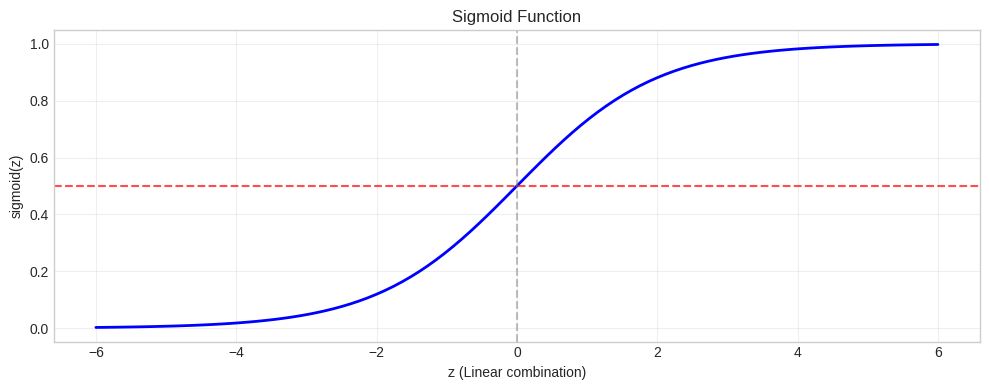

In [ ]:
from matplotlib.lines import lineStyles
z = np.linspace(-6, 6, 100)
sigmoid = 1 / (1 + np.exp(-z))

plt.figure(figsize=(10, 4))
plt.plot(z, sigmoid, 'b-', linewidth=2)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("z (Linear combination)")
plt.ylabel("sigmoid(z)")
plt.title("Sigmoid Function")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

columns =  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigree', 'Age', 'Outcome']

df = pd.read_csv(url , names=columns)

print(f"{df.shape[0]} samples, {df.shape[1]} columns")
df.head()

768 samples, 9 columns


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
#Target Distribution
print(f"Class Distribution: \n{df['Outcome'].value_counts()}")
print(f"\nDiabetes rate: {df['Outcome'].mean():.1%}")

Class Distribution: 
Outcome
0    500
1    268
Name: count, dtype: int64

Diabetes rate: 34.9%


In [ ]:
#Handle zeros, although it is impossible for some features such as pregnancies
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

df[zero_cols] = df[zero_cols].replace(0, np.nan)
df = df.fillna(df.median())

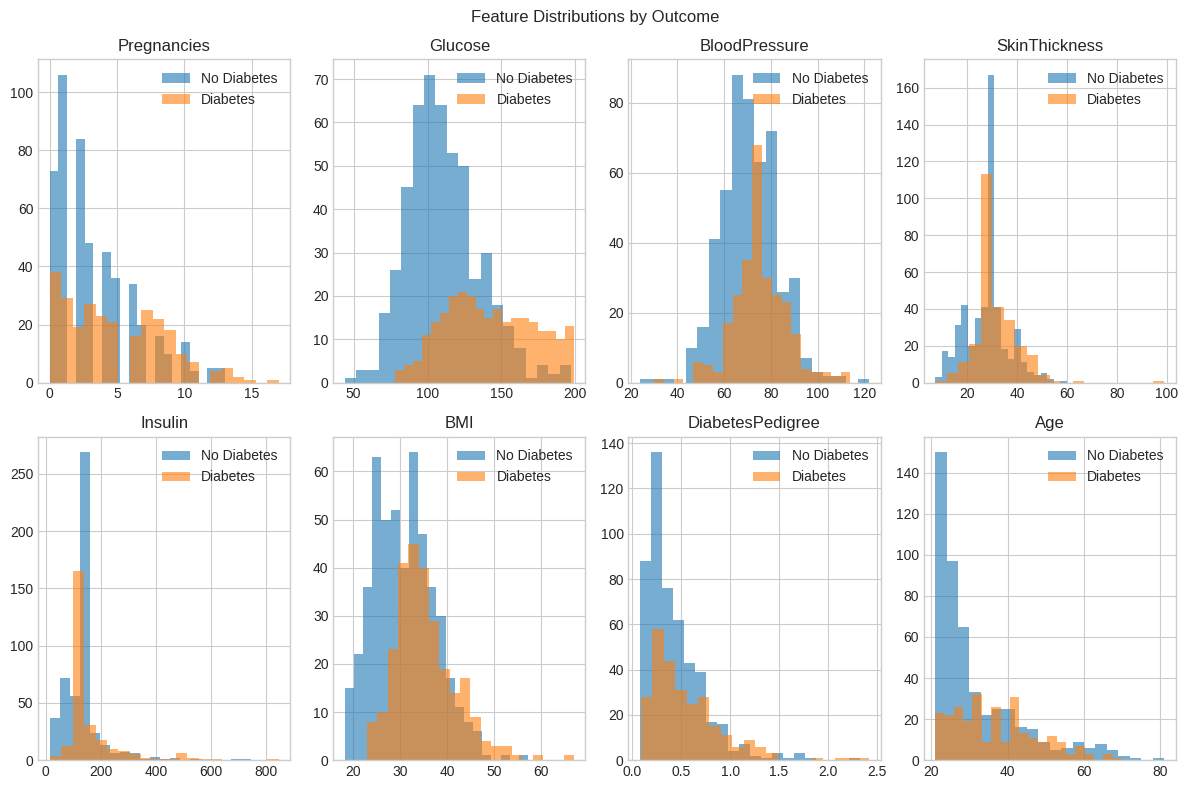

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, columns[:-1]):
  df[df['Outcome']==0][col].hist(ax=ax, alpha=0.6, label='No Diabetes', bins=20)
  df[df['Outcome']==1][col].hist(ax=ax, alpha=0.6, label='Diabetes', bins=20)
  ax.set_title(col)
  ax.legend()

plt.suptitle("Feature Distributions by Outcome")
plt.tight_layout()
plt.show()

Train Logistic Regression

In [ ]:
x = df.drop('Outcome', axis=1)
y = df['Outcome']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

#Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f"Train: {x_train.shape[0]}, test: {x_test.shape[0]}")

Train: 614, test: 154


In [ ]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)
y_prob = model.predict_proba(x_test_scaled)[:, 1]

#Evaluate
print("Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.2%}")

Model Performance:
Accuracy: 70.78%
Precision: 60.00%
Recall: 50.00%
F1 Score: 54.55%
ROC AUC Score: 81.30%


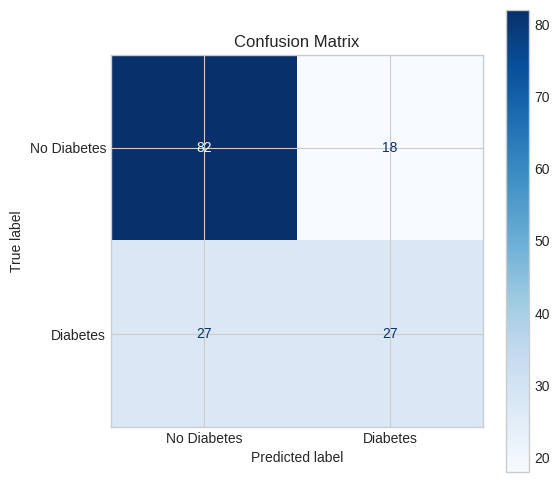

In [ ]:
#Cunfusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['No Diabetes', 'Diabetes'], cmap='Blues', ax=ax)
ax.set_title("Confusion Matrix")
plt.show()

Interpreting Coefficients

In [ ]:
coef_df = pd.DataFrame({
    'Feature': x.columns,
    'Coefficient': model.coef_[0],
    'Odds ratio': np.exp(model.coef_[0])
}).sort_values('Coefficient', key=abs, ascending=False)

print('Coefficient Interpretation:')
print(coef_df.round(3).to_string(index=False))

Coefficient Interpretation:
         Feature  Coefficient  Odds ratio
         Glucose        1.183       3.263
             BMI        0.689       1.991
     Pregnancies        0.378       1.459
DiabetesPedigree        0.233       1.263
             Age        0.148       1.159
         Insulin       -0.066       0.936
   BloodPressure       -0.044       0.957
   SkinThickness        0.028       1.029


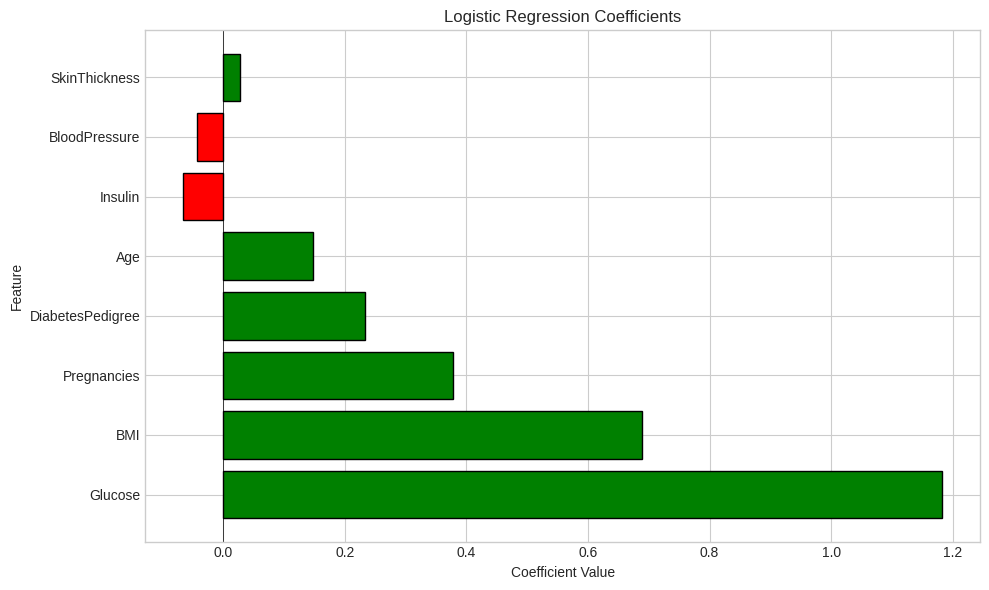

In [ ]:
#Visualizing Coeffs
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in coef_df['Coefficient']]
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Feature')
ax.set_title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()

Decision Boundary

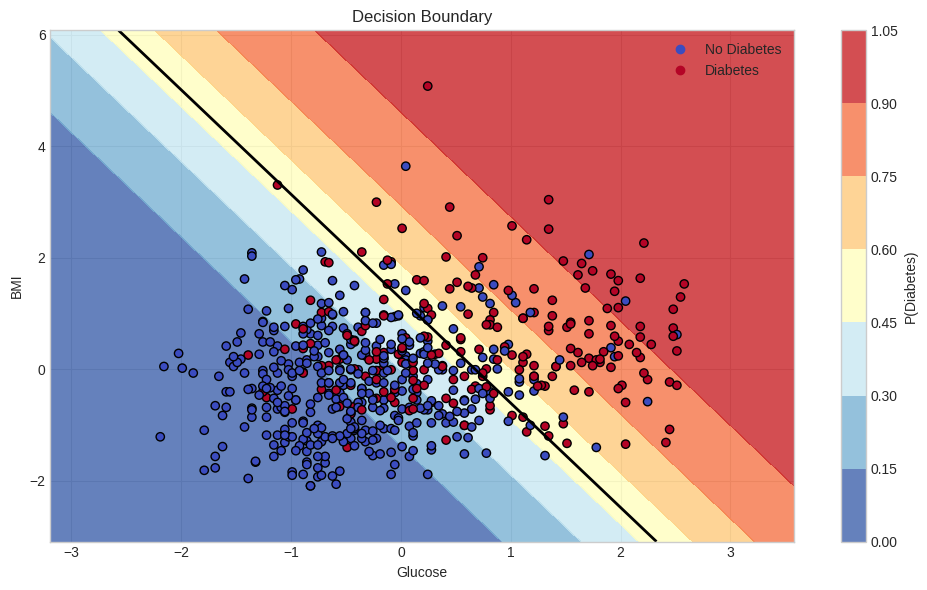

In [ ]:
#Visualizing the decision boundary using the two most important features
x_2d = x_train_scaled[:, [1, 5]] #glucode, BMI
model_2d = LogisticRegression(random_state=42).fit(x_2d, y_train)

#Create mesh
x_min, x_max = x_2d[:, 0].min() - 1, x_2d[:, 0].max() + 1
y_min, y_max = x_2d[:, 1].min() - 1, x_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

z = model_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
z = z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, z, cmap='RdYlBu_r', alpha=0.8)
plt.colorbar(label='P(Diabetes)')
plt.contour(xx, yy, z, levels=[0.5], colors='black', linewidths=2)
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_train, cmap='coolwarm', edgecolors='black')
plt.legend(handles=scatter.legend_elements()[0], labels=['No Diabetes', 'Diabetes'])
plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.title('Decision Boundary')
plt.tight_layout()
plt.show()

Threshold Tuning

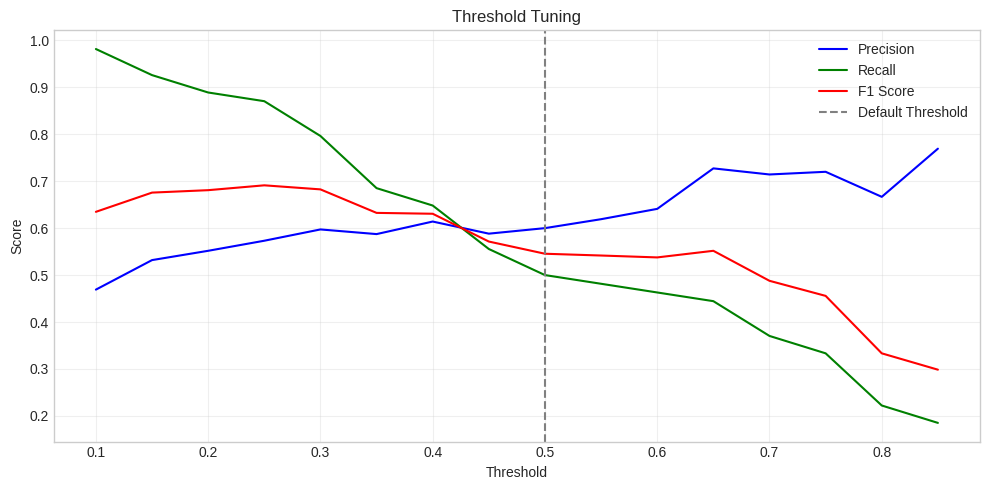

Best Threshold: 0.25


In [31]:
#Default threshold is 0.5, but we can tune it
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
  y_pred_t = (y_prob >= thresh).astype(int)
  results.append({
      'Threshold': thresh,
      'Precision': precision_score(y_test, y_pred_t, zero_division=0),
      'Recall': recall_score(y_test, y_pred_t),
      'F1': f1_score(y_test, y_pred_t, zero_division=0)
  })

thresh_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
plt.plot(thresh_df['Threshold'], thresh_df['Precision'], 'b-', label='Precision')
plt.plot(thresh_df['Threshold'], thresh_df['Recall'], 'g-', label='Recall')
plt.plot(thresh_df['Threshold'], thresh_df['F1'], 'r-', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning')
plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
#
best_f1_idx = thresh_df['F1'].idxmax()
print(f"Best Threshold: {thresh_df.loc[best_f1_idx, 'Threshold']:.2f}")
#

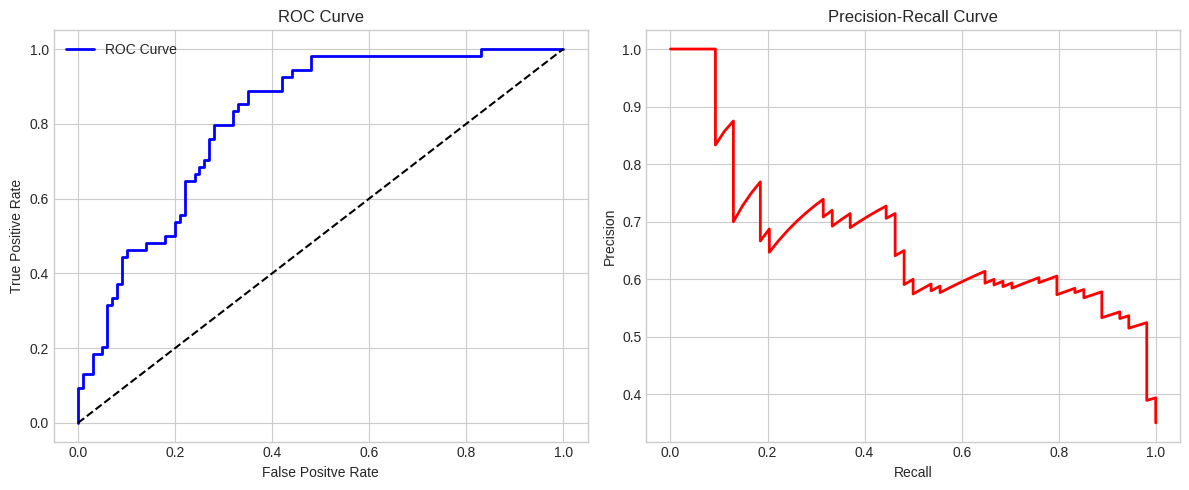

In [32]:
#ROC and Precision-Recall curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label='ROC Curve')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positve Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title("ROC Curve")
axes[0].legend()

#precision recall curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
axes[1].plot(rec, prec, 'r-', linewidth=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

Regularization

In [35]:
results = []
for penalty, solver in [('l1', 'liblinear'), ('l2', 'lbfgs'),
                        ('elasticnet', 'saga')]:
  if penalty == 'elasticnet':
    model_reg = LogisticRegression(penalty=penalty,
                                   solver=solver,
                                   l1_ratio=0.5, max_iter=1000, random_state=42)
  else:
    model_reg = LogisticRegression(penalty=penalty, solver=solver,
                                   max_iter=1000, random_state=42)

  cv_scores = cross_val_score(model_reg, x_train_scaled, y_train, cv=5, scoring='roc_auc')
  model_reg.fit(x_train_scaled, y_train)
  n_nonzero = np.sum(model_reg.coef_ != 0)

  results.append({
      'Penalty': penalty.upper(),
      'CV AUC': f"{cv_scores.mean():.3f} (+-{cv_scores.std():.3f})",
      'Non-zero Coefs': n_nonzero
  })

  print("Regularization comparison:")
  print(pd.DataFrame(results).to_string(index=False))

Regularization comparison:
Penalty          CV AUC  Non-zero Coefs
     L1 0.842 (+-0.029)               8
Regularization comparison:
Penalty          CV AUC  Non-zero Coefs
     L1 0.842 (+-0.029)               8
     L2 0.843 (+-0.029)               8
Regularization comparison:
   Penalty          CV AUC  Non-zero Coefs
        L1 0.842 (+-0.029)               8
        L2 0.843 (+-0.029)               8
ELASTICNET 0.842 (+-0.030)               8


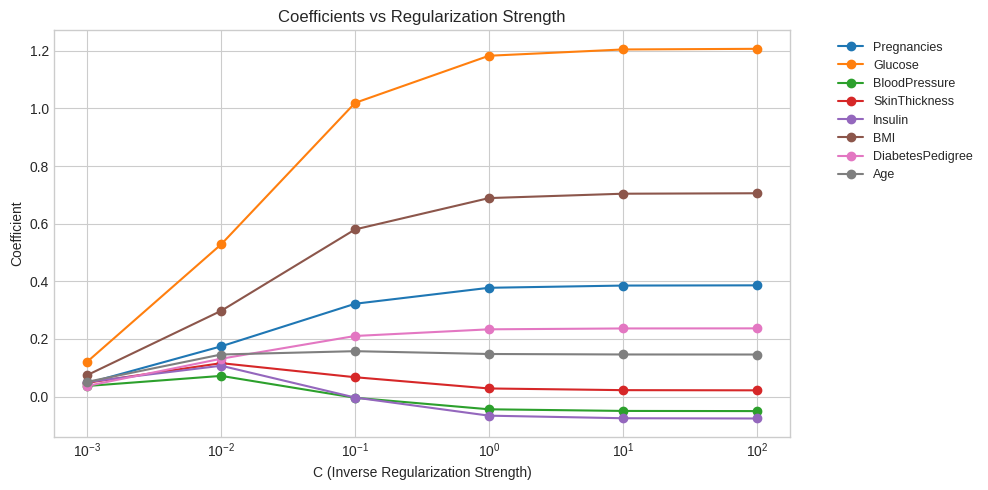

Low C = strong regularization (coefficients shrink)
High C = weak regularization (coefficients grow)


In [37]:
# Effect of regularization strength (C parameter)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
coefs_by_C = []

for C in C_values:
    model_c = LogisticRegression(C=C, max_iter=1000, random_state=42)
    model_c.fit(x_train_scaled, y_train)
    coefs_by_C.append(model_c.coef_[0])

coefs_by_C = np.array(coefs_by_C)

plt.figure(figsize=(10, 5))
for i, feat in enumerate(x.columns):
    plt.plot(C_values, coefs_by_C[:, i], 'o-', label=feat)
plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Coefficient')
plt.title('Coefficients vs Regularization Strength')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

print("Low C = strong regularization (coefficients shrink)")
print("High C = weak regularization (coefficients grow)")

Final Model with CV

In [39]:
model_cv = LogisticRegressionCV(Cs=np.logspace(-3, 3, 20), cv=5, scoring='roc_auc',
                                max_iter=1000, random_state=42)
model_cv.fit(x_train_scaled, y_train)

print(f"Optimal c: {model_cv.C_[0]:.3f}")

y_pred_final = model_cv.predict(x_test_scaled)
y_prob_final = model_cv.predict_proba(x_test_scaled)[:, 1]

print(f"Final Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.2%}")
print(f"Precision: {precision_score(y_test, y_pred_final):.2%}")
print(f"Recall: {recall_score(y_test, y_pred_final):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred_final):.2%}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_final):.2%}")

Optimal c: 0.695
Final Model Performance:
Accuracy: 69.48%
Precision: 57.45%
Recall: 50.00%
F1 Score: 53.47%
ROC AUC Score: 81.26%
